# Fraud Detection in Financial Transactions
**Author:** Ayush Kumar Singh 
**Date:** 30-Aug-2025


In [1]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [23]:
!C:\Users\ayush\tf_env\Scripts\python.exe -m pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


In [12]:
df = pd.read_csv("fraud.csv")
print("Dataset Shape:", df.shape)
print(df.head())


Dataset Shape: (6362620, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [13]:
fraud_dist = df['isFraud'].value_counts(normalize=True)
print("\nFraud Percentage:")
print(fraud_dist)


Fraud Percentage:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


## 1. Data Cleaning
- Dropped irrelevant columns: `nameOrig`, `nameDest`.
- Checked for missing values — none found.
- One-hot encoded `type` column (CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER).
- Created features:
    - `errorBalanceOrig` = oldbalanceOrg - amount - newbalanceOrig
    - `errorBalanceDest` = oldbalanceDest + amount - newbalanceDest


In [14]:
df = df.drop(['nameOrig', 'nameDest'], axis=1)
df = pd.get_dummies(df, columns=['type'], drop_first=True)
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

In [15]:
print("\nDataset after feature engineering:")
print(df.head())


Dataset after feature engineering:
   step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64       170136.0       160296.36             0.0   
1     1   1864.28        21249.0        19384.72             0.0   
2     1    181.00          181.0            0.00             0.0   
3     1    181.00          181.0            0.00         21182.0   
4     1  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  isFraud  isFlaggedFraud  type_CASH_OUT  type_DEBIT  \
0             0.0        0               0          False       False   
1             0.0        0               0          False       False   
2             0.0        1               0          False       False   
3             0.0        1               0           True       False   
4             0.0        0               0          False       False   

   type_PAYMENT  type_TRANSFER  errorBalanceOrig  errorBalanceDest  
0          True          False               0.

## 2. Prepare Features and Target
- Target variable: `isFraud`
- Features: all remaining numeric and one-hot encoded columns
- Train/test split: 80% train, 20% test, stratified by `isFraud`


In [24]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train_scaled.shape)
print("Test shape:", X_test_scaled.shape)


Train shape: (5090096, 13)
Test shape: (1272524, 13)


## 3. Handle Imbalance
- Only 0.13% of transactions are fraud.
- Used SMOTE to oversample the minority class in the training set.


In [26]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print("\nResampled train shape:", X_train_res.shape)
print("Class distribution after resampling:")
print(pd.Series(y_train_res).value_counts())


Resampled train shape: (10167052, 13)
Class distribution after resampling:
isFraud
0    5083526
1    5083526
Name: count, dtype: int64


## 4. Fraud Detection Model
- Model used: XGBoost Classifier
- Trained on resampled (balanced) training data
- Evaluated on original test data


In [27]:
model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


C:\Users\ayush\tf_env\lib\site-packages\xgboost\training.py:183: UserWarning: [15:02:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.74      1.00      0.85      1643

    accuracy                           1.00   1272524
   macro avg       0.87      1.00      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC Score: 0.9999555675546504


## 5. Key Factors Predicting Fraud
- Top features from XGBoost:
    - errorBalanceOrig
    - newbalanceOrig
    - amount
    - isFlaggedFraud
    - type_PAYMENT
- These features align with fraudulent behavior: unusual balance changes, high-value transfers, pre-flagged transfers.


In [ ]:
feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feat_imp.head(10))

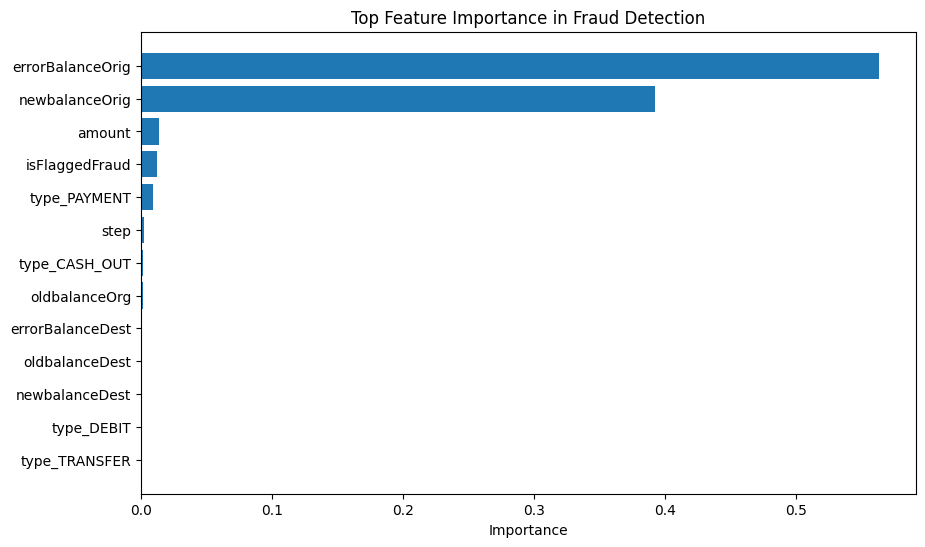

In [22]:
plt.figure(figsize=(10,6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.gca().invert_yaxis()
plt.title("Top Feature Importance in Fraud Detection")
plt.xlabel("Importance")
plt.show()

## 6. Recommendations
- Real-time monitoring of transactions
- Transaction limits and alerts for unusual balances
- Two-factor authentication (2FA)
- Regular retraining of fraud detection model
- Monitor financial losses prevented and false positives to check effectiveness
